In [1]:
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import os
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
plt.rcParams.update({'font.size': 18})

In [2]:
# Import the function definitions that accompany this notebook tutorial.
nb_funcdef_file = "function_defs.py"
if os.path.isfile(nb_funcdef_file):
    from function_defs import make_lightcurve, listdir_contains
else:
    raise IOError("Could not find function definition file '" + nb_funcdef_file + "' that goes with this notebook.")

In [3]:
# Restore the output directory.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the location of the products made from the "generate_products" notebook.
%store -r data_directory
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the location of the output products.
#data_directory = "./raw_files/"

In [4]:
# Restore the skypos parameter.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the sky position to use.
%store -r skypos
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the sky position in degrees.
#skypos = (24.76279, -17.94948)

In [5]:
# Locate the photon files.
photon_files = {'NUV':listdir_contains(data_directory,'nd.csv'),
                'FUV':listdir_contains(data_directory,'fd.csv')}

In [6]:
# Since this flare has such a large count rate, we can make a 5-second light curve to explore it's shape in detail.
# Flare #8 is in Visit #5 (index 4 in our array of .csv files.)
lc_nuv = make_lightcurve(photon_files['NUV'][4], 'NUV', stepsz=5., skypos=skypos, quiet=True, makefile=False)
lc_fuv = make_lightcurve(photon_files['FUV'][4], 'FUV', stepsz=5., skypos=skypos, fixed_t0=lc_nuv['t0'].min(),
                             quiet=True, makefile=False)

Max. cps for FUV = 158.7857090114415
Max. cps for NUV = 838.5825824857579


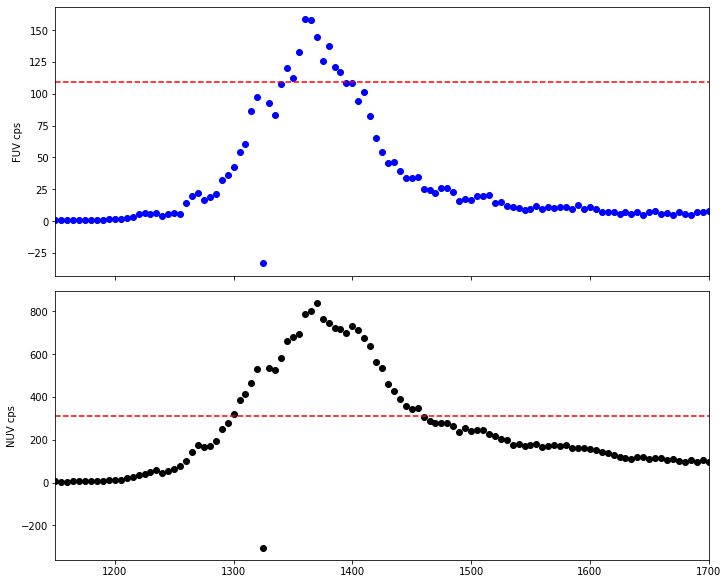

In [7]:
# The flare can get quite bright.  Let's check the counts per second to make sure none of them
# exceed the non-linearity regime of the GALEX detectors.
# We flag any points above 10% the local non-linearity dropoff of the detectors.  These values
# are taken from the Morrissey et al. 2017 GALEX calibration paper.
nuv_10p_nonlincps = 311.
fuv_10p_nonlincps = 109.
print("Max. cps for FUV = " + str(max(lc_fuv['cps'])))
print("Max. cps for NUV = " + str(max(lc_nuv['cps'])))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True, sharex=True)
ax1.plot(lc_fuv['t0']-lc_fuv['t0'][0], lc_fuv['cps'], 'bo')
ax2.plot(lc_nuv['t0']-lc_nuv['t0'][0], lc_nuv['cps'], 'ko')
ax1.axhline(fuv_10p_nonlincps, color='r', linestyle='--')
ax2.axhline(nuv_10p_nonlincps, color='r', linestyle='--')
ax1.set_xlim(1150.,1700.)
ax2.set_xlim(1150.,1700.)
ax1.set_ylabel("FUV cps")
ax2.set_ylabel("NUV cps")
plt.show()

In [8]:
# Read in FUV and NUV effective area curves from the SVO Profile Filter Service.  Effective area curves are in cm**2.
fuv_wls, fuv_effareas = np.genfromtxt("GALEX_GALEX.FUV.dat.txt", unpack=True, dtype=float)
nuv_wls, nuv_effareas = np.genfromtxt("GALEX_GALEX.NUV.dat.txt", unpack=True, dtype=float)

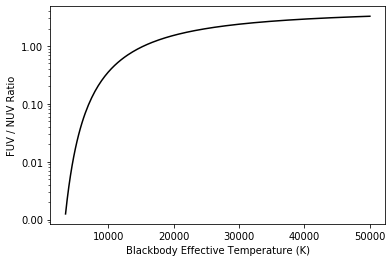

In [9]:
# Compute the expected FUV/NUV ratios in the GALEX passbands for a variety of blackbody temperatures, following the
# work done by Robinson et al. 2005, ApJ, 633, 447.
blackbody_temps = np.arange(3500, 50100, 250)
fuv_nuv_ratios = []
for temp in blackbody_temps:
    # blackbody_lambda returns fluxes in erg/cm**2/s/Angstrom/sr.  Multiplying by effective area curve gets fluxes
    # in erg/s/Angstrom/sr.  Multiplying by the FUV and NUV effective widths results in erg/s/sr.
    bb_cont_fuv = blackbody_lambda(in_x=fuv_wls, temperature=temp * u.Kelvin) * fuv_effareas / np.trapz(fuv_wls,
                                                                                                        fuv_effareas)
    bb_cont_nuv = blackbody_lambda(in_x=nuv_wls, temperature=temp * u.Kelvin) * nuv_effareas / np.trapz(nuv_wls,
                                                                                                       nuv_effareas)
    fuv_nuv_ratio = np.trapz(fuv_wls, bb_cont_fuv) / np.trapz(nuv_wls, bb_cont_nuv)
    fuv_nuv_ratios.append(fuv_nuv_ratio)
# Convert to a numpy array so we can use the where() functionality.
fuv_nuv_ratios = np.asarray(fuv_nuv_ratios)
# Plot the evolution of the FUV to NUV ratio as a function of blackbody temperature.
fig, ax = plt.subplots(1)
ax.plot(blackbody_temps, fuv_nuv_ratios, '-k')
ax.semilogy()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("Blackbody Effective Temperature (K)")
ax.set_ylabel("FUV / NUV Ratio")
plt.show()

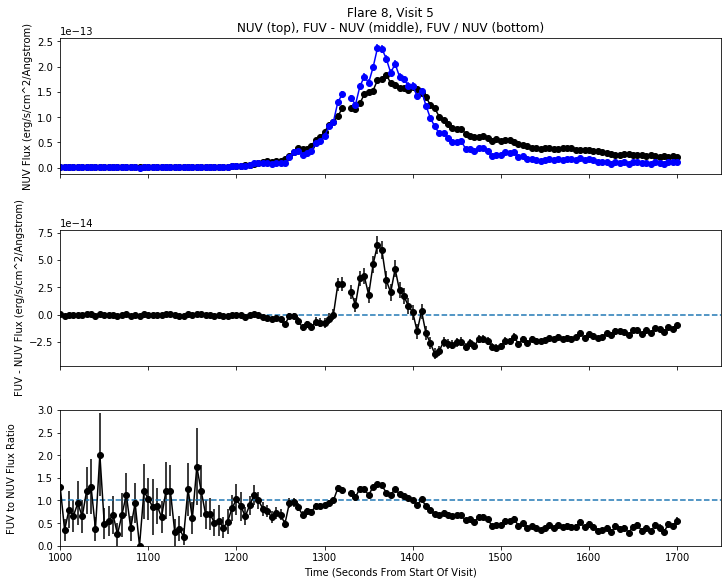

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True, sharex=True)
# Original flare light curve.
ax0.errorbar((lc_nuv['t0']-min(lc_nuv['t0'])), lc_nuv['flux_apcorrected'], yerr=lc_nuv['flux_err'], fmt='-ko')
ax0.errorbar((lc_fuv['t0']-min(lc_nuv['t0'])), lc_fuv['flux_apcorrected'], yerr=lc_fuv['flux_err'], fmt='-bo')
ax0.set_xlim(1000., 1750.)
ax0.set_ylabel("NUV Flux (erg/s/cm^2/Angstrom)")
ax0.set_title("Flare 8, Visit 5\nNUV (top), FUV - NUV (middle), FUV / NUV (bottom)")

# FUV - NUV flux difference and propagated uncertainties: delta_z = SQRT(delta_x**2 + delta_y**2)
diff = lc_fuv['flux_apcorrected'] - lc_nuv['flux_apcorrected']
diff_err = (lc_nuv['flux_err']**2. + lc_fuv['flux_err']**2.)**0.5
ax1.errorbar((lc_nuv['t0']-min(lc_nuv['t0'])), diff, yerr=diff_err, fmt='-ko')
ax1.set_xlim(1000., 1750.)
ax1.axhline(0.0, linestyle='--')
ax1.set_ylabel("FUV - NUV Flux (erg/s/cm^2/Angstrom)")

# FUV / NUV flux ratio and propated uncertainties: delta_z / z = SQRT((delta_x/x)**2 + (delta_y/y)**2)
ratio = lc_fuv['flux_apcorrected'] / lc_nuv['flux_apcorrected']
ratio_err = ratio * ((lc_nuv['flux_err']/lc_nuv['flux_apcorrected'])**2. +
                     (lc_fuv['flux_err']/lc_fuv['flux_apcorrected'])**2.)**0.5
ax2.errorbar((lc_nuv['t0']-min(lc_nuv['t0'])), ratio, yerr=ratio_err, fmt='-ko')
ax2.set_xlim(1000., 1750.)
ax2.set_ylim(0., 3.)
ax2.axhline(1.0, linestyle='--')
ax2.set_xlabel("Time (Seconds From Start Of Visit)")
ax2.set_ylabel("FUV to NUV Flux Ratio", labelpad=20)
fig.savefig("figures/flare8_diff-and-ratio.eps", dpi=600)

In [11]:
# What is the maximum and minimum FUV/NUV ratio once the flare starts?
flare_start_time = 1200.
where_flare = np.where(lc_nuv['t0']-min(lc_nuv['t0']) >= flare_start_time)[0]
min_ratio = np.nanmin(ratio[where_flare])
max_ratio = np.nanmax(ratio[where_flare])
print("Min. and Max. FUV/NUV Ratio During Flare: {0:f} and {1:f}.".format(min_ratio, max_ratio))

Min. and Max. FUV/NUV Ratio During Flare: 0.290751 and 1.368307.


In [ ]:
# What would the approximate blackbody temperature be for these ratios assuming the flux is dominated by blackbody
# emission?
where_min = np.argmin(abs(fuv_nuv_ratios - min_ratio))
where_max = np.argmin(abs(fuv_nuv_ratios - max_ratio))
print("Approximate blackbody temperature at minimum ratio of {0:f}: {1:f}".format(min_ratio,
                                                                                  blackbody_temps[where_min]))
print("Approximate blackbody temperature at maximum ratio of {0:f}: {1:f}".format(max_ratio,
                                                                                  blackbody_temps[where_max]))

In [ ]:
ts = np.asarray(lc_nuv['t0']-min(lc_nuv['t0']))
diff = np.asarray(diff)
where_below0 = np.where((diff > 0.) & (ts > 1200.) & (ts < 1500.))[0]
print(ts[where_below0])
print(len(where_below0))